<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [30]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
%run plot_functions/plot_settings.py

# Exercise 6 - Linear FEM: soil column under gravity and top load

## Governing differential equation

Consider the equilibrium conditions on an infinitesimal element of the soil column:

$$
    \downarrow: \quad F_z + \frac{\partial F_z}{\partial z}\text{d}z - F_z + \varrho g A \text{d}z = 0
$$

The vertical force is determined by $F_z = \sigma_{zz}A = E_\text{s} A \epsilon_{zz} = -E_\text{s} A u_{z,z}$. Therefore, the equilibrium conditions read:

$$
    0 = \left[ \frac{\partial}{\partial z} \left(E_\text{s} A \frac{\partial u_z}{\partial z}\right) - \varrho g A \right]\text{d}z
$$

Considering, that the equation has to hold for an arbitrary infinitesimal non-zero $\text{d}z$, we find the ordinary differential equation

$$
    0 = \frac{\partial}{\partial z} \left(E_\text{s} A \frac{\partial u_z}{\partial z}\right) - \varrho g A
$$

Nota bene: compare this to the differential equation for a rod ('Zugstab'): $(EAu')' + n = 0$. While the cross section of a rod can vary along its length, the cross-sectional area of a soil column is considered a constant, simplifying the equation further:

$$
    0 = \frac{\partial}{\partial z} \left(E_\text{s} \frac{\partial u_z}{\partial z}\right) - \varrho g
$$

## Weak form

The displacements can have (the essential/Dirichlet) boundary conditions in the form:

$$
    u = \bar{u}\ \forall z \in \partial \Omega_\mathrm{D}% \qquad \text{and} \qquad - E_\text{s}A \frac{\partial u_z}{\partial z} = \bar{F} \ \forall z \in \partial \Omega_\mathrm{N}
$$

We now introduce a test function $\delta u$ (virtual displacement) which vanishes where the displacement is given

$$
    \delta u = 0\ \forall z \in \partial \Omega_\mathrm{D}
$$

and construct the weak form (using integration by parts):

\begin{align}
   0 &= \int \limits_0^H \left[\frac{\partial}{\partial z} \left(E_\text{s} \frac{\partial u_z}{\partial z}\right) - \varrho g\right] \delta u\, \text{d}z
   \\
   &= \int \limits_0^H \left[\frac{\partial}{\partial z} \left(E_\text{s} \frac{\partial u_z}{\partial z} \delta u \right) - \frac{\partial \delta u}{\partial z} E_\text{s} \frac{\partial u_z}{\partial z} - \varrho g \delta u \right] \, \text{d}z
\end{align}

Integrating the first term yields the natural/Neumann boundary conditions, so that
$$
\left[ \underbrace{E_\text{s} \frac{\partial u_z}{\partial z}}_{\displaystyle -\bar{\sigma}_z} \delta u \right]_0^H - \int \limits_0^H \varrho g \delta u \text{d}z = \int \limits_0^H \frac{\partial \delta u}{\partial z} E_\text{s} \frac{\partial u_z}{\partial z} \, \text{d}z
$$
which is recognised as the principal of virtual work: $\delta W_\text{ext} = \delta W_\text{int}$.

## Finite elements in 1D

We have a soil column of $H=20$ m on top of the bed rock at $z=0$.

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [31]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [32]:
def number_of_nodes(nelems,nodes_per_elem):
    return nelems*nodes_per_elem - (nelems - 1)

def generate_mesh(domain_length,nelems,nodes_per_elem):
    nn = number_of_nodes(nelems,nodes_per_elem)
    #coordinate vector of global nodes
    global_nodal_coordinates = np.linspace(0.,domain_length,nn)
    global_solution = np.array([0.]*nn)
    
    #generate elements
    element_vector = []
    for i in range(nelems):
        node_start = (nodes_per_elem-1)*i
        element_vector.append(
            line_element(nodes_per_elem,
                         global_nodal_coordinates[node_start:node_start+nodes_per_elem],
                         list(range(node_start,node_start+nodes_per_elem))))
        
    return global_nodal_coordinates, element_vector, global_solution

Let's put this to test.

In [33]:
number_of_elements = 30
L = 10.
nodes_per_element = 3

nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)

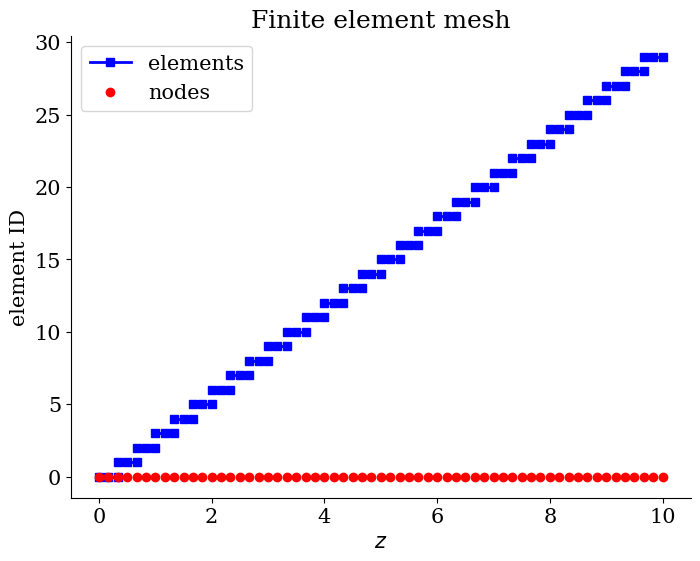

In [34]:
plt.xlabel('$z$')
plt.ylabel('element ID')
plt.title('Finite element mesh')
for i,elem in enumerate(elements):
    if (i==0):
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-', label='elements')
    else:
        plt.plot(elem._line_element__coords,[i]*elem._line_element__nnodes, 'bs-')
plt.plot(nodes, [0]*len(nodes), 'ro ', label='nodes')
plt.legend();

## Shape functions in 1D

Now we have a mesh consisting of a vector of elements, and a global node vector. The next ingredient required are the shape functions for the elements in order to interpolate variables and determine gradients.

### Linear elements

Linear elements have two nodes with $\xi_1 = -1$ and $\xi_2 = 1$. The linear shape functions are

$$
    N_1(\xi) = \frac{1-\xi}{2} \qquad \text{and} \qquad N_2(\xi) = \frac{1+\xi}{2}
$$

Their gradients in natural coordinates follow as

$$
    \frac{\text{d} N_1}{\text{d}\xi} = - \frac{1}{2} \qquad \text{and} \qquad \frac{\text{d} N_2}{\text{d}\xi} = \frac{1}{2}
$$

### Quadratic elements

Quadratic elements have three nodes with $\xi_1 = -1$, $\xi_2 = 0$ and $\xi_3 = 1$. The quadratic shape functions are

$$
    N_1(\xi) = \frac{\xi (\xi - 1)}{2}, \qquad N_2(\xi) = (1-\xi)(1+\xi) \qquad \text{and} \qquad N_3(\xi) = \frac{\xi(1+\xi)}{2}
$$

Their gradients in natural coordinates follow as

$$
    \frac{\text{d} N_1}{\text{d}\xi} = \xi - \frac{1}{2}, \qquad \frac{\text{d} N_2}{\text{d}\xi} = -2\xi \qquad \text{and} \qquad \frac{\text{d} N_3}{\text{d}\xi} = \xi + \frac{1}{2}
$$

### Jacobians and gradients

An unknown is approximated as $u \approx N_i \hat{u}_i$ where $i$ runs over all nodes of a given element and $\hat{u}_i$ are the nodal degrees of freedom. To peform a gradient calculation (here in 1D) 

$$
    \text{grad} u = \frac{\text{d} u}{\text{d} z} = \frac{\text{d}N_i}{\text{d} z} \hat{u}_i = \frac{\text{d}N_i}{\text{d} \xi} \frac{\text{d}\xi}{\text{d} z} \hat{u}_i = \frac{\text{d}N_i}{\text{d} \xi} J^{-1} \hat{u}_i
$$

The element Jacobian follows from the isoparametric coordinate approximation $z \approx N_i \hat{z}_i$ where $\hat{z}_i$ are the nodal coordinates:

$$
    J = \frac{\text{d} z}{\text{d}\xi} = \frac{\text{d} N_i}{\text{d}\xi} \hat{z}_i
$$

We use the following shorthand:

$$
    \nabla N_i = \frac{\text{d}N_i}{\text{d} z} = \frac{\text{d}N_i}{\text{d} \xi} J^{-1}
$$

In [35]:
#N
def shape_function(element_order,xi):
    if (element_order == 2): #-1,1
            return np.array([(1.-xi)/2., (1.+xi)/2.])
    elif (element_order == 3): #-1, 0, 1
            return np.array([(xi - 1.)*xi/2., (1-xi)*(1+xi), (1+xi)*xi/2.])
#dN_dxi
def dshape_function_dxi(element_order,xi):
    if (element_order == 2): #-1,1
        return np.array([-0.5*xi/xi, 0.5*xi/xi])  #xi only later for plotting dimensions
    elif (element_order == 3):#-1,0,1
        return np.array([xi - 0.5,-2.*xi,xi + 0.5])

#dz_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dz
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac


Now let's plot the shape functions to see if they were implemented correctly.

In [36]:
def plot_shape_functions(order):
    xi = np.linspace(-1.,1.,100)
    fig, ax = plt.subplots(ncols=2)
    ax[0].set_xlabel('$\\xi$')
    ax[0].set_ylabel('$N(\\xi)$')
    for i in range(order):
        ax[0].plot(xi,shape_function(order,xi)[i],label='$N_{%i}$' %i)
    ax[0].legend()
    ax[1].set_xlabel('$\\xi$')
    ax[1].set_ylabel('$\\mathrm{d}N(\\xi)/\\mathrm{d}\\xi$')
    for i in range(order):
        ax[1].plot(xi,dshape_function_dxi(order,xi)[i],label='$\\mathrm{d}N_{%i}/\\mathrm{d}\\xi$' %i)
    ax[1].legend()
    fig.tight_layout()

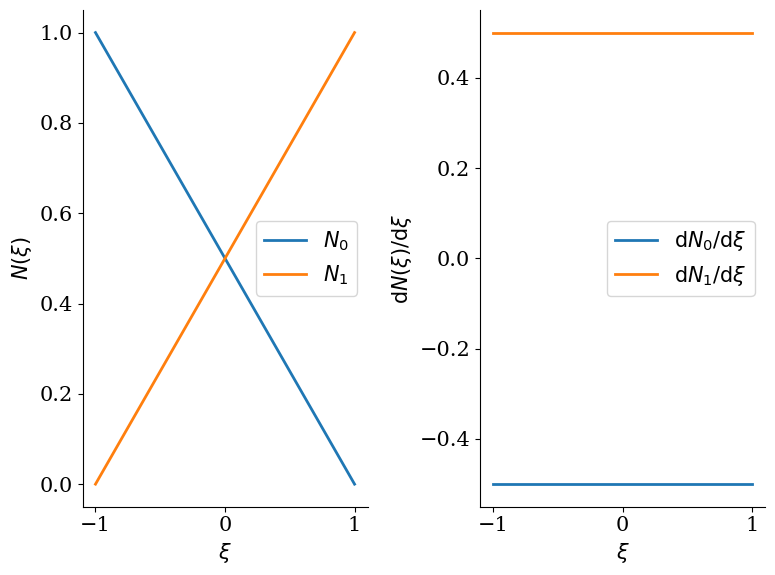

In [37]:
plot_shape_functions(2)

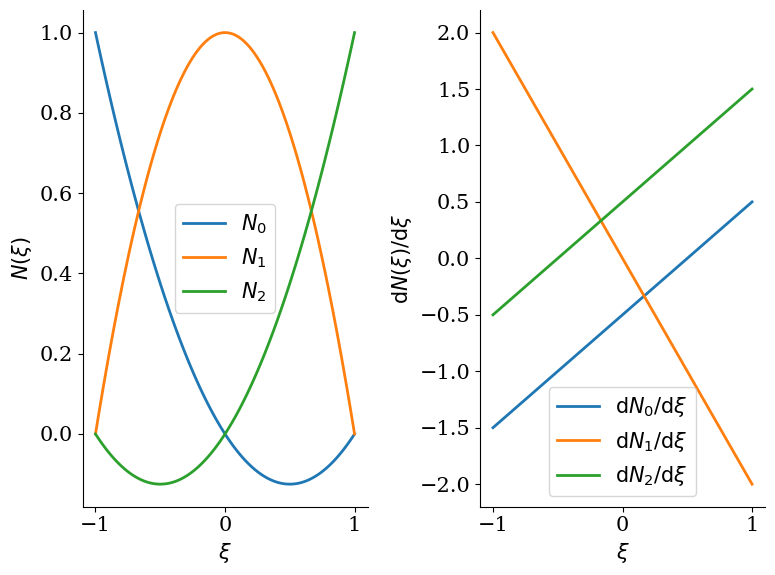

In [38]:
plot_shape_functions(3)

## Discretization of virtual work (weak form)

Now let's write the discretized version of the principal of virtual work in the following form:
$$
\left[ \bar{\sigma}_z \delta u \right]_0^H - \int \limits_0^H \varrho g \delta u \text{d}z = \int \limits_0^H \frac{\partial \delta u}{\partial z} E_\text{s} \frac{\partial u_z}{\partial z} \, \text{d}z
$$

using 

$$
    u \approx N_i \hat{u}_i, \quad \delta u \approx N_i \delta \hat{u}_i, \quad \frac{\partial u_z}{\partial z} \approx \nabla N_i \hat{u}_i, \quad \frac{\partial \delta u_z}{\partial z} \approx \nabla N_i \delta \hat{u}_i
$$

This yields

$$
\begin{aligned}
    \int \limits_0^H \varrho g \delta u\, \text{d}z &= \int \limits_0^H \varrho g \delta u\, \text{d}z = \int \limits_0^H \varrho g N_i\, \text{d}z\ \delta \hat{u}_i= \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \varrho g N_i \det J \, \text{d}\xi\ \delta \hat{u}_i
    \\
    \int \limits_0^H \frac{\partial \delta u}{\partial z} E_\text{s} \frac{\partial u_z}{\partial z} \, \text{d}z &=  \int \limits_0^H \nabla N_i E_\text{s} \nabla N_k  \, \text{d}z \ \hat{u}_k \delta \hat{u}_i = \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i E_\text{s} \nabla N_k \det J  \, \text{d}\xi \ \hat{u}_k \delta \hat{u}_i
    \\
    \left[ \bar{\sigma}_z \delta u \right]_0^H &= \bar{\sigma}_z(z=H) \delta \hat{u}_{n_\text{n}} - \bar{\sigma}_z(z=0) \delta \hat{u}_0 = \left[ \bar{\sigma}_z(z=H) \delta_{in_\text{n}} - \bar{\sigma}_z(z=0) \delta_{i0} \right] \delta \hat{u}_i
\end{aligned}
$$

where in the last step we assumed that the node at $z=0$ has the node id $0$, while the node at $z=H$ has the node id $n_\text{n}$.

The discretized system

$$
    \left[ \bar{\sigma}_z(z=H) \delta_{in_\text{n}} - \bar{\sigma}_z(z=0) \delta_{i0} - \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \varrho g N_i \det J \, \text{d}\xi \right] \delta \hat{u}_i = \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i E_\text{s} \nabla N_k \det J  \, \text{d}\xi \ \hat{u}_k \delta \hat{u}_i
$$

can be simplified by realizing that the nodal virtual displacements are arbitrary and thus

$$
    \bar{\sigma}_z(z=H)\delta_{in_\text{n}} - \bar{\sigma}_z(z=0) \delta_{i0} - \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \varrho g N_i \det J \, \text{d}\xi = \bigcup \limits_{e=1}^{n_\text{el}} \int \limits_{z_e} \nabla N_i E_\text{s} \nabla N_k \det J  \, \text{d}\xi \ \hat{u}_k
$$

which leaves us with $n_\text{n}$ equations for the $n_\text{n}$ unknown nodal displacements $\hat{u}_k$. This is the discretized force balance with

$$
    F_i^\text{surf} + F_i^\text{body} = K_{ik} \hat{u}_k
$$

What we require now is the local assembler to calculate the stiffness matrix and the local right-hand side. Local integration is performed by Gauss quadrature:

$$
    \int \limits_{-1}^1 f(\xi)\,\text{d}\xi \approx \sum \limits_{i=1}^{n_\text{gp}} f(\xi_i) w_i 
$$

## Local assember

In [39]:
def Stiffness(z):
    E0 = 1.e8 #Pa
    return E0

def Density(z):
    rho0 = 2600.*(1.-0.38) #kg/m³
    return rho0

def BodyForce(z):#N/m
    g = -9.81
    return g*Density(z)

In [40]:
def local_assembler(elem):
    element_order = elem._line_element__nnodes
    K_loc = np.zeros((element_order,element_order))
    b_loc = np.zeros(element_order)
    z_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]
        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(z_glob)
        #evaluation of local body force
        rho_g = BodyForce(z_glob)
        
        #assembly of local stiffness matrix
        K_loc += np.outer(dN_dX,dN_dX) * E * w * detJ
        
        #assembly of local RHS
        b_loc += N * rho_g * w * detJ
    return K_loc,b_loc

In [41]:
local_assembler(elements[3])

(array([[ 7.0e+08, -8.0e+08,  1.0e+08],
        [-8.0e+08,  1.6e+09, -8.0e+08],
        [ 1.0e+08, -8.0e+08,  7.0e+08]]),
 array([ -878.54, -3514.16,  -878.54]))

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [42]:
def global_assembler(nodes,elements,solution):
    K_glob = np.zeros((len(nodes),len(nodes)))
    b_glob = np.zeros(len(nodes))
    for i,elem in enumerate(elements):
        K_i, b_i = local_assembler(elem)
        start_id = elem._line_element__global_ids[0]
        end_id = elem._line_element__global_ids[-1]
        K_glob[start_id:end_id+1,start_id:end_id+1] += K_i
        b_glob[start_id:end_id+1] += b_i
    return K_glob, b_glob

## Application of boundary conditions

Now we apply the natural (Neumann, nodal force) and the essential (Dirichlet, nodal displacement) boundary conditions.

A nodal force $F_\text{bc}$ at node $m$ is simply added by
$$
    F^\text{ext}_i = \left(
        \begin{array}{c}
            F_0\\ F_1\\ \vdots\\ F_m \\ \vdots \\ F_{n_\text{n}}
        \end{array}
    \right)
     = F_i^\text{body} + F_\text{bc} \delta_{im} = F_i^\text{body} + F_\text{bc}
     \left(
        \begin{array}{c}
            0\\ 0\\ \vdots \\ 1 \\ \vdots \\ 0
        \end{array}
    \right)
$$

In [43]:
def apply_Neumann_bc(b_glob,node_id,value):
    b_glob[node_id] += value
    return b_glob

A Dirichlet boundary condition $\bar{u}$ at node $m$ is introduced into the system $K_{ik} u_k = f_i$ via

$$
    \left(
    \begin{array}{c}
        K_{11} & K_{12} & \dots & K_{1m} & \dots & K_{1n_\text{n}}
        \\
        K_{21} & K_{22} & \dots & K_{2m} & \dots & K_{2n_\text{n}}
        \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
        \\
        K_{m1}:=0 & K_{m2}:=0 & \dots & K_{mm}:=1 & \dots & K_{mn_\text{n}}:=0
        \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
        \\
        K_{n_\text{n}1} & K_{n_\text{n}2} & \dots & K_{n_\text{n}m} & \dots & K_{n_\text{n}n_\text{n}}
    \end{array}    
    \right)
    \left(
    \begin{array}{c}
            u_0\\ u_1\\ \vdots\\ u_m \\ \vdots \\ u_{n_\text{n}}
        \end{array}
    \right)
    =
    \left(
    \begin{array}{c}
            F_0\\ F_1\\ \vdots\\ F_m:=\bar{u} \\ \vdots \\ F_{n_\text{n}}
        \end{array}
    \right)
$$

In [44]:
def apply_Dirichlet_bc(K_glob,b_glob,node_id,value):
    K_glob[node_id,:] = 0.# = K_glob[:,node_id] = 0.
    K_glob[node_id,node_id] = 1.
    b_glob[node_id] = value
    return K_glob, b_glob

## Problem solution

We now perform the global assembly, apply a vanishing traction on the top and constrain the displacement at the bottom to zero.

In [45]:
number_of_elements = 20
L = 10.
nodes_per_element = 2

nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)

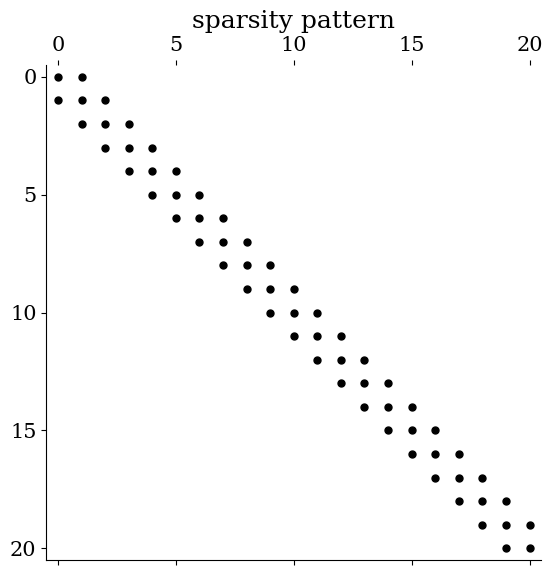

In [46]:
K, f = global_assembler(nodes,elements,solution)
plt.spy(K,marker='.')
plt.title('sparsity pattern')
plt.tight_layout()

In [47]:
f = apply_Neumann_bc(f,len(nodes)-1,0)

In [48]:
K, f = apply_Dirichlet_bc(K, f, 0, -1.)

In [49]:
solution = np.linalg.solve(K,f)

In [51]:
reference_z = np.linspace(0,L,100)
reference_solution = ((reference_z/L)**2 - 2.*reference_z/L) * BodyForce(0) * L**2 / (2.*Stiffness(0))

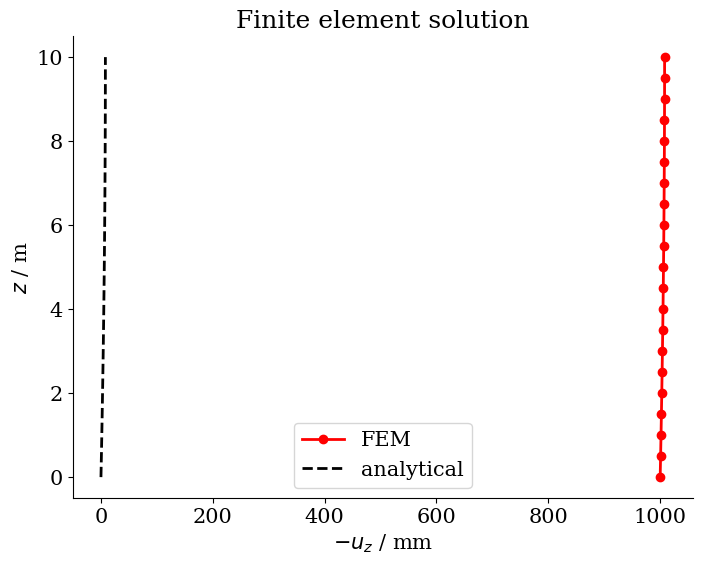

In [52]:
plt.ylabel('$z$ / m')
plt.xlabel('$-u_z$ / mm')
plt.title('Finite element solution')
plt.plot(-solution*1e3, nodes, 'ro-', label='FEM')
plt.plot(reference_solution*1e3, reference_z, ls='--', color='black', label='analytical')
plt.legend();

### Convergence study

Let's do a simple convergence study.

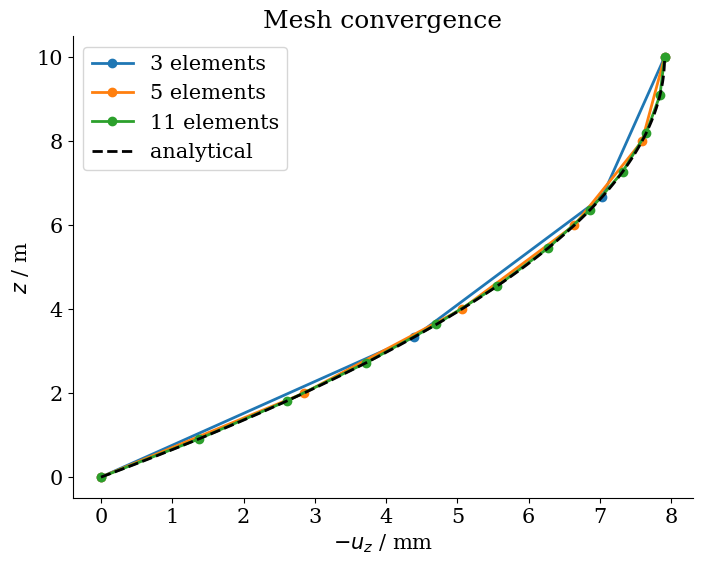

In [23]:
plt.ylabel('$z$ / m')
plt.xlabel('$-u_z$ / mm')
plt.title('Mesh convergence')
for i in [3,5,11]:
    number_of_elements = i
    nodes_per_element = 2
    nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)
    K, f = global_assembler(nodes,elements,solution)
    f = apply_Neumann_bc(f,len(nodes)-1,0)
    K, f = apply_Dirichlet_bc(K, f, 0, 0.)
    solution = np.linalg.solve(K,f)
    plt.plot(-solution*1e3, nodes, marker = 'o', label='%i elements' %i)
plt.plot(reference_solution*1e3, reference_z, ls='--', color='black', label='analytical')
plt.legend();

That's quite boring. Let's make the case a little bit more interesting, by giving the stiffness a variation with depth and by applying a compressive traction at the surface.

In [24]:
Stiffness = lambda x: 1.e8+0.8e8*np.sin(x) #Pa
sig_top = - 300e3#Pa

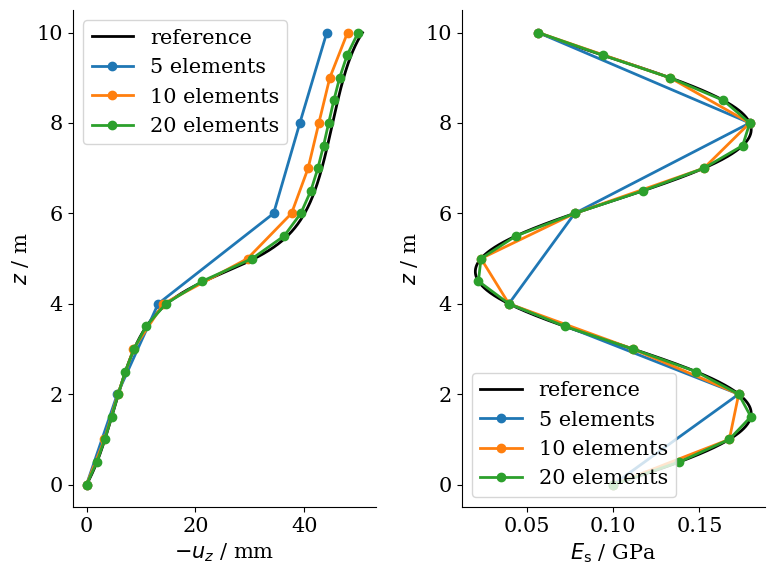

In [25]:
fig, ax = plt.subplots(ncols=2)
ax[0].set_ylabel('$z$ / m')
ax[1].set_ylabel('$z$ / m')
ax[0].set_xlabel('$-u_z$ / mm')
ax[1].set_xlabel('$E_\\mathrm{s}$ / GPa')
nodes_per_element = 2
finest = 1000
for i in [finest,5,10,20]:
    number_of_elements = i
    nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)
    K, f = global_assembler(nodes,elements,solution)
    f = apply_Neumann_bc(f,len(nodes)-1,sig_top)
    K, f = apply_Dirichlet_bc(K, f, 0, 0.)
    solution = np.linalg.solve(K,f)
    if (i == finest):
        ax[1].plot(Stiffness(nodes)/1e9, nodes, label='reference',color='black')
        ax[0].plot(-solution*1e3, nodes, label='reference',color='black')
    else:
        ax[1].plot(Stiffness(nodes)/1e9, nodes, marker = 'o', label='%i elements' %i)
        ax[0].plot(-solution*1e3, nodes, marker = 'o', label='%i elements' %i)
ax[0].legend();
ax[1].legend();
fig.tight_layout()

Something similar can be done to demonstrate the effect of higher-order elements.

In [26]:
def run_sim(npe,ne):
    nodes,elements,solution=generate_mesh(L,ne,npe)
    K, f = global_assembler(nodes,elements,solution)
    f = apply_Neumann_bc(f,len(nodes)-1,sig_top)
    K, f = apply_Dirichlet_bc(K, f, 0, 0.)
    solution = np.linalg.solve(K,f)
    return nodes, solution, K

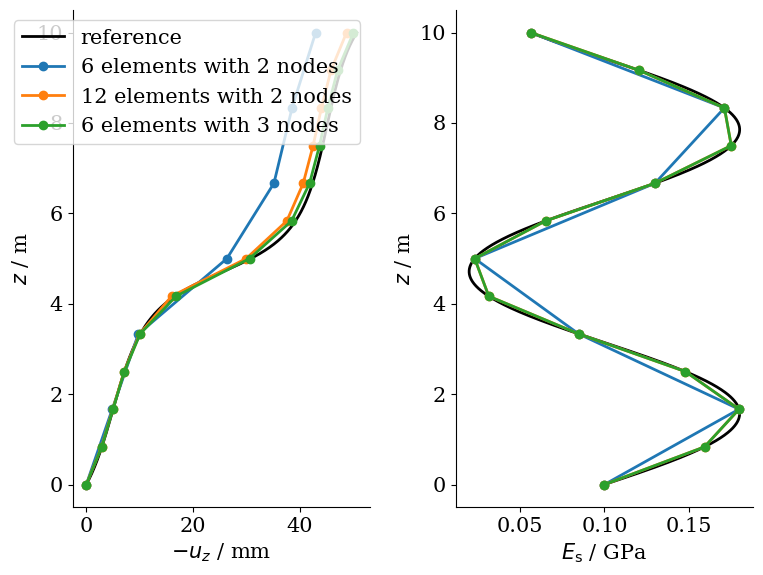

In [27]:
fig, ax = plt.subplots(ncols=2)
ax[0].set_ylabel('$z$ / m')
ax[1].set_ylabel('$z$ / m')
ax[0].set_xlabel('$-u_z$ / mm')
ax[1].set_xlabel('$E_\\mathrm{s}$ / GPa')
#reference
nodes, solution, matrix = run_sim(2,1000)
ax[0].plot(-solution*1e3, nodes, label='reference',color='black')
ax[1].plot(Stiffness(nodes)/1e9, nodes, label='reference',color='black')
#10 linear elements
nodes, solution, matrix = run_sim(2,6)
ax[0].plot(-solution*1e3, nodes, label='6 elements with 2 nodes',marker='o')
ax[1].plot(Stiffness(nodes)/1e9, nodes, label='6 elements with 2 nodes',marker='o')
#20 linear elements
nodes, solution, matrix = run_sim(2,12)
ax[0].plot(-solution*1e3, nodes, label='12 elements with 2 nodes',marker='o')
ax[1].plot(Stiffness(nodes)/1e9, nodes, label='12 elements with 2 nodes',marker='o')
#10 quadratic elements
nodes, solution, matrix = run_sim(3,6)
ax[0].plot(-solution*1e3, nodes, label='6 elements with 3 nodes',marker='o')
ax[1].plot(Stiffness(nodes)/1e9, nodes, label='6 elements with 3 nodes',marker='o')

ax[0].legend()
fig.tight_layout();

We see that with the same number of nodes, the higher-order approximation is better. *Note* that the lines connecting the nodal values are linear here, whereas the actual approximation between the nodes of one element is quadratic and thus smoother than shown here!

## Interactive playground

In [28]:
from ipywidgets import widgets
from ipywidgets import interact
#Compute reference solution with 100 cells
nodes_ref, solution_ref, matrix_ref = run_sim(2,1000)

@interact(num_nodes=widgets.IntSlider(min=3, max=41, value=9, step=2, description='nodes'),
         npes=widgets.RadioButtons(options=[1,2], value=2, description='element order',))
def plot(num_nodes=5,npes=2):
    fig,ax = plt.subplots(ncols=2)
    ax[0].set_ylabel('$z$ / m')
    ax[0].set_xlabel('$-u_z$ / mm')
    num_cells = int((num_nodes - 1)/(npes))
    x, u, matrix = run_sim(npes+1,num_cells)
    ax[0].plot(-solution_ref*1e3, nodes_ref, '--', color='k', label='reference solution');
    ax[0].plot(-u*1e3,x,'o-', label=str(len(x)) + ' nodes');
    ax[0].legend(loc='lower left')
    ax[1].spy(matrix,marker='.')
    plt.show()

interactive(children=(IntSlider(value=9, description='nodes', max=41, min=3, step=2), RadioButtons(description…

And here's a convergence plot in terms of number of nodes for linear (blue) and quadratic (red) elements. We see that, despite the more complicated problem, the observed convergence order of the FEM scheme is much higher than with the FDM scheme for this type of problem.

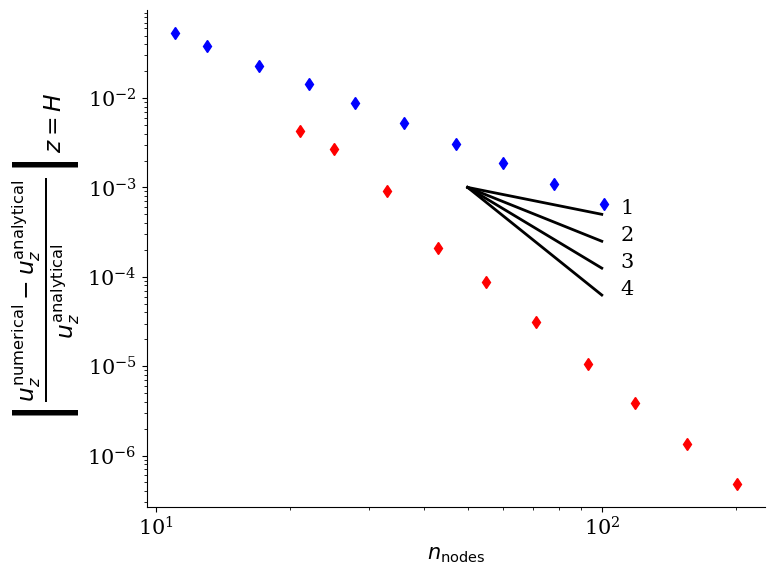

In [29]:
#HIDDEN
fig, ax = plt.subplots()
disc_n = np.logspace(1,2,10)
z, analytical, K = run_sim(3,1000)
analytical_top = analytical[-1]
for nn in disc_n:
    z, numerical, K = run_sim(2,int(nn))
    numerical_top = numerical[-1]
    relerr = np.abs((numerical_top - analytical_top)/analytical_top)
    ax.plot(len(z),relerr,ls='',marker='d',color='blue')
    z, numerical, K = run_sim(3,int(nn))
    numerical_top = numerical[-1]
    relerr = np.abs((numerical_top - analytical_top)/analytical_top)
    ax.plot(len(z),relerr,ls='',marker='d',color='red')
ax.plot([5e1,1e2],[1e-3,1e-3/2],ls='-',color='black')
ax.text(1.1e2,1e-3/2,'1')
ax.plot([5e1,1e2],[1e-3,1e-3/4],ls='-',color='black')
ax.text(1.1e2,1e-3/4,'2')
ax.plot([5e1,1e2],[1e-3,1e-3/8],ls='-',color='black')
ax.text(1.1e2,1e-3/8,'3')
ax.plot([5e1,1e2],[1e-3,1e-3/16],ls='-',color='black')
ax.text(1.1e2,1e-3/16,'4')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$n_\\mathrm{nodes}$')
ax.set_ylabel('$\\left| \\frac{u_z^\\mathrm{numerical} - u_z^\\mathrm{analytical}}{u_z^\\mathrm{analytical}} \\right|_{z=H}$',size=24)
fig.tight_layout();